# HOMEWORK 3: INTERACTIVE VIZ

In [2]:
import folium
import pandas as pd
import numpy as np
import json
import requests
from bs4 import BeautifulSoup
from lxml import etree
import requests
from IPython.display import display, HTML
import re
import matplotlib.pyplot as plt

First, the data is imported and inspected: 

In [3]:
projects_url= r'P3_GrantExport.csv'
projects_data = pd.read_csv(projects_url, sep=';')
projects_data.set_index(projects_data.columns[0], inplace=True)
print(projects_data.shape)
projects_data.head()

(63969, 14)


,Project Title,Project Title English,Responsible Applicant,Funding Instrument,Funding Instrument Hierarchy,Institution,University,Discipline Number,Discipline Name,Discipline Name Hierarchy,Start Date,End Date,Approved Amount,Keywords
"﻿""Project Number""",,,,,,,,,,,,,,
1,Schlussband (Bd. VI) der Jacob Burckhardt-Biog...,NaN,Kaegi Werner,Project funding (Div. I-III),Project funding,NaN,Nicht zuteilbar - NA,10302,Swiss history,Human and Social Sciences;Theology & religious...,01.10.1975,30.09.1976,11619.00,NaN
4,Batterie de tests à l'usage des enseignants po...,NaN,Massarenti Léonard,Project funding (Div. I-III),Project funding,Faculté de Psychologie et des Sciences de l'Ed...,Université de Genève - GE,10104,Educational science and Pedagogy,"Human and Social Sciences;Psychology, educatio...",01.10.1975,30.09.1976,41022.00,NaN
5,"Kritische Erstausgabe der ""Evidentiae contra D...",NaN,Kommission für das Corpus philosophorum medii ...,Project funding (Div. I-III),Project funding,Kommission für das Corpus philosophorum medii ...,"NPO (Biblioth., Museen, Verwalt.) - NPO",10101,Philosophy,Human and Social Sciences;Linguistics and lite...,01.03.1976,28.02.1985,79732.00,NaN
6,Katalog der datierten Handschriften in der Sch...,NaN,Burckhardt Max,Project funding (Div. I-III),Project funding,Abt. Handschriften und Alte Drucke Bibliothek ...,Universität Basel - BS,10302,Swiss history,Human and Social Sciences;Theology & religious...,01.10.1975,30.09.1976,52627.00,NaN
7,Wissenschaftliche Mitarbeit am Thesaurus Lingu...,NaN,Schweiz. Thesauruskommission,Project funding (Div. I-III),Project funding,Schweiz. Thesauruskommission,"NPO (Biblioth., Museen, Verwalt.) - NPO",10303,Ancient history and Classical studies,Human and Social Sciences;Theology & religious...,01.01.1976,30.04.1978,120042.00,NaN


From all this information only two features are relevant: "University" and "Approved Amount". 

In [4]:
projects_data = projects_data[['University', 'Approved Amount']]
print(projects_data.shape)
projects_data.head()

(63969, 2)


,University,Approved Amount
"﻿""Project Number""",,
1,Nicht zuteilbar - NA,11619.00
4,Université de Genève - GE,41022.00
5,"NPO (Biblioth., Museen, Verwalt.) - NPO",79732.00
6,Universität Basel - BS,52627.00
7,"NPO (Biblioth., Museen, Verwalt.) - NPO",120042.00


Then the data is cleaned. Note that some data that is not relevant to our study is dropped: NA universities, firms and corporations, libraries, museums... 
Also, there is data not included in P3.

In [5]:
projects_data.dropna(subset=['University'], inplace=True)
projects_data = projects_data[projects_data['University'] != 'Nicht zuteilbar - NA'] #Nicht zuteilbar = NA University
projects_data = projects_data[projects_data['University'] != 'Firmen/Privatwirtschaft - FP'] #Firmen/Privatwirtschaft = Private corporations
projects_data = projects_data[projects_data['University'] != 'NPO (Biblioth., Museen, Verwalt.) - NPO'] #NPO = is not university
index = projects_data[projects_data['Approved Amount'] == 'data not included in P3'].index
projects_data = projects_data.drop(index)
print(projects_data.shape)
projects_data.head()

(46318, 2)


,University,Approved Amount
"﻿""Project Number""",,
4,Université de Genève - GE,41022.00
6,Universität Basel - BS,52627.00
8,Université de Fribourg - FR,53009.00
9,Université de Fribourg - FR,25403.00
10,Universität Zürich - ZH,47100.00


The main challenge of this assignment is to map each university to a Canton of Switzerland. To achieve this, a search in GeoNames by the university name will be performed. The functions for this are presented below:

In [6]:
def searchCantonGeoNames(query1, query2=None): #returns in which canton the university is in
    url = 'http://api.geonames.org/searchJSON?country=CH&maxRows=1&username=jnls'
    payload = {'q': query1 }
    req = requests.get(url, params=payload)
    req_json = json.loads(req.text)
    if req_json['totalResultsCount'] > 0:
        return req_json['geonames'][0]['adminCode1']
    elif req_json['totalResultsCount'] == 0 and query2 is not None:
        payload = {'q': query2 }
        req = requests.get(url, params=payload)
        req_json = json.loads(req.text)
        if req_json['totalResultsCount'] > 0:
            return req_json['geonames'][0]['adminCode1']
        else:
            return "NaN"
def search_cantons(data):
    uc_data = data['University'].drop_duplicates().to_frame()
    uc_data['Canton'] = ''
    for i in range(len(uc_data)):
        query = uc_data['University'].iloc[i].split(" - ")
        if len(query) > 1:
            canton = searchCantonGeoNames(query[0], query[1])
        else:
            canton = searchCantonGeoNames(query[0])
        uc_data['Canton'].iloc[i] = canton
    #data = data[data['Canton'] != 'NaN'] 
    return uc_data

If this search does not provide all the required data, a search in P3 will be performed in order to retrieve the postcode of each university. Then, a second search in GeoNames will be performed, but this time using the postcode: 

In [7]:
def getData(project_id):
    url = 'http://p3.snf.ch'
    url_project = url + '/project-' + str(project_id)
    # We parse the response to analyze it 
    soup_project = BeautifulSoup(requests.request("GET", url_project).text, 'html.parser')
    id_institute = soup_project.find(id="ctl00_MainContent_urlInstitite").get('href')
    if id_institute is None:
        return None
    
    url_institute = url + id_institute
    
    toSoup = requests.request("GET", url_institute)
    soup_institute = BeautifulSoup(toSoup.text, 'html5lib')
    table = soup_institute.findAll('div', {'class': 'institute'})[0].findAll('td')[1].text
    p = re.compile("CH-\S{4}")
    match = p.search(table)
    
    if match is None:
        return None
    #print(project_id, match.group(0))
    postal_code = match.group(0)
    return postal_code

def search_missing_cantons(uc_data):
    for i in range(len(uc_data)):
        if uc_data['Canton'].iloc[i] == 'NaN':
            query = getData(temp.index.values[i])
            if query is not None:
                canton = searchCantonGeoNames(query)
            uc_data['Canton'].iloc[i] = canton
    return uc_data

The Canton data is retrievied:

In [8]:
temp = search_cantons(projects_data)
temp = search_missing_cantons(temp)
temp.head()

,University,Canton
"﻿""Project Number""",,
4,Université de Genève - GE,GE
6,Universität Basel - BS,BS
8,Université de Fribourg - FR,FR
10,Universität Zürich - ZH,ZH
11,Université de Lausanne - LA,VD


How many universities left?

In [9]:
temp[temp['Canton'].isnull()]['University']

﻿"Project Number"
260                  Pädagogische Hochschule Zürich - PHZFH
3315      Swiss Center for Electronics and Microtech. - ...
10947              Università della Svizzera italiana - USI
26632     Centre de rech. sur l'environnement alpin - CR...
59733                       Fachhochschule Ostschweiz - FHO
101005                            Forschungskommission SAGW
139469                  Facoltà di Teologia di Lugano - FTL
Name: University, dtype: object

The remaining university data is hardcoded:

In [10]:
temp['Canton'].loc[260] = 'ZH'
temp['Canton'].loc[3315] = 'VS'
temp['Canton'].loc[10947] = 'TI' 
temp['Canton'].loc[26632] = 'VS'
temp['Canton'].loc[59733] = 'SG'
temp['Canton'].loc[101005] = 'BE'
temp['Canton'].loc[139469] = 'TI'

First, the data is converted to a dictionary and mapped. The Aproved Amount is converted to float. Finally, the sum of the grant per canton is calculated. 

In [12]:
temp.set_index(temp.University, inplace=True, drop=True)
temp = temp.to_dict()['Canton']
projects_data['Canton'] = projects_data['University'].map(temp)
projects_data.reset_index(drop=True, inplace=True)
grants = projects_data.drop('University', 1)
grants['Approved Amount'] = grants['Approved Amount'].apply(pd.to_numeric)
grants_sum = grants.groupby(grants.Canton).sum()/10**6
grant_canton = grants_sum['Approved Amount'].to_dict()
print(grant_canton)

{'AR': 2.1202809999999999, 'AG': 122.87069587000001, 'TG': 4.0189810000000001, 'ZH': 3730.4700682899997, 'UR': 38.864231600000004, 'VS': 50.263556200000004, 'BL': 42.771914120000005, 'NE': 383.83196229999993, 'GR': 39.378188000000002, 'BE': 1558.0548332900003, 'SZ': 0.93655100000000002, 'VD': 2400.2252164499996, 'BS': 1392.4979069799997, 'GE': 1883.9834929599997, 'SG': 91.194102450000003, 'FR': 459.07366825000014, 'TI': 116.1932829, 'SH': 0.17669099999999999, 'LU': 72.700549670000001}


Another dictionary is created with the acronym for each Canton (the acronyms are the same as defined in the "ch-cantons.topojson.json" file given). With this data the map is created as defined by the folium API.

In [19]:
cantonMap = pd.DataFrame({'Canton':['JU', 'ZH', 'BE', 'LU', 'SG', 'NE', 
                                    'VD', 'VS', 'GE', 'TI', 'SO', 'UR', 
                                    'OW', 'NW', 'SZ', 'GL', 'ZG', 'BL', 
                                    'BS', 'FR', 'SH', 'AR', 'AI', 'GR', 
                                    'AG', 'TG']})
cantonMap['Grants'] = 0
cantonMap['Grants'] = cantonMap['Canton'].map(grant_canton)
ch_geo = r'ch-cantons.topojson.json'

mapCH = folium.Map(location=[46.8,8.2], zoom_start=8)
mapCH.choropleth(data=cantonMap, 
                columns=['Canton', 'Grants'], 
                geo_path=ch_geo,
                topojson='objects.cantons', 
                threshold_scale=[2, 100, 1000, 2000, 2500, 3000],
                fill_color='BuPu', fill_opacity=0.7, line_opacity=0.5,
                key_on='feature.id')
mapCH.save('ch-cantons.html')

In [20]:
%%HTML
<iframe width="100%" height="500" src="ch-cantons.html"></iframe>

Some additional data is displayed in order to understand how the grants are distributed by university and by canton:

                              Total income
Université de Neuchâtel - NE    383.204582
Université de Fribourg - FR     457.526170
EPF Lausanne - EPFL            1175.315914
Université de Lausanne - LA    1183.290757
Universität Basel - BS         1352.251464
Universität Bern - BE          1519.373035
ETH Zürich - ETHZ              1635.596618
Universität Zürich - ZH        1826.842675
Université de Genève - GE      1838.237308


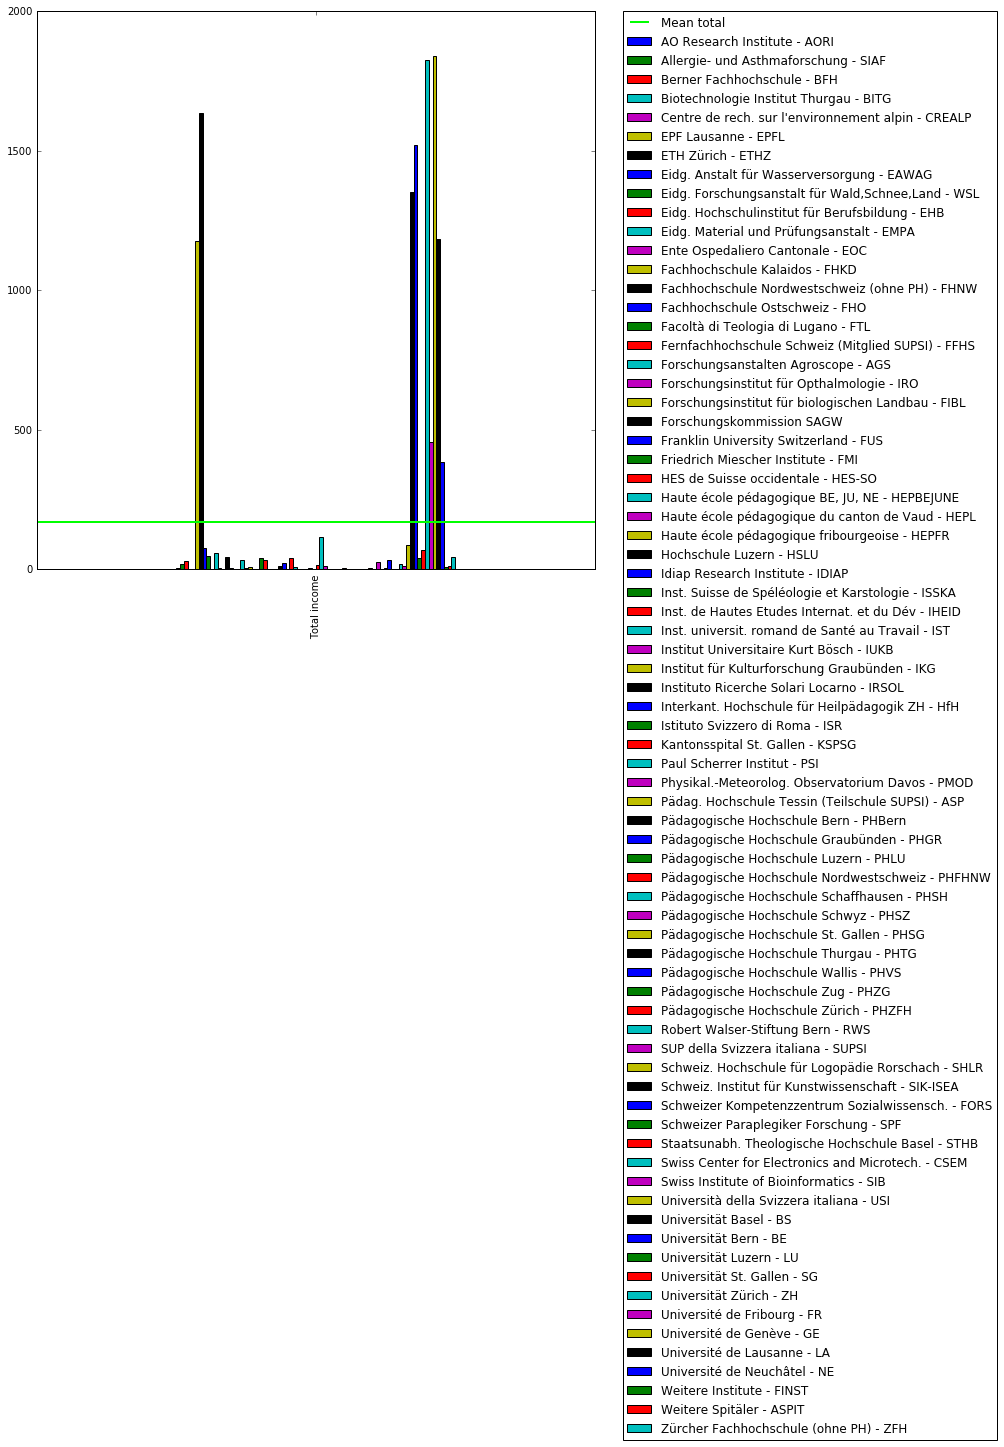

In [27]:
moneyXuni = {}
for university in np.unique(projects_data['University'].values):
    moneyXuni[university] = sum(projects_data[projects_data['University'] == university ]['Approved Amount'].values.astype(np.float))/10**6

data_MU = pd.DataFrame(moneyXuni, index = ['Total income']) #data Money per University
%matplotlib inline
data_MU.plot.bar(figsize=(10, 10))
mean = sum(list(moneyXuni.values())) / len(moneyXuni)
plt.axhline(y = mean, xmin=0, xmax=1, hold=None, color='#00FF00', linewidth = 2.0, label = 'Mean total')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
selected_uni = (data_MU.transpose()[data_MU.transpose()['Total income'] > mean]).sort_values(by =['Total income'])
print(selected_uni)
plt.show()

/Users/dmartr/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


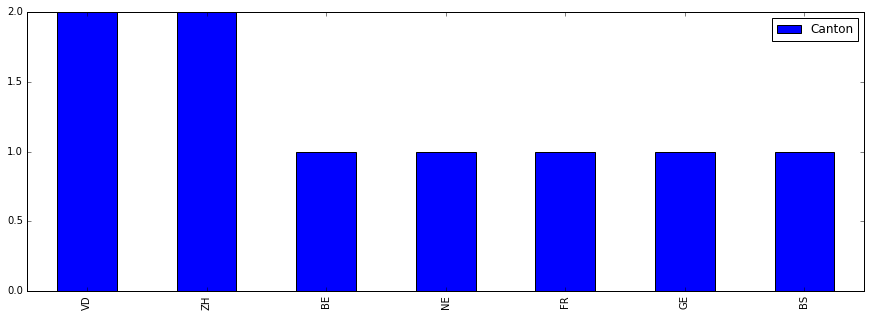

In [25]:
selected_uni['Canton'] = ''
for i in selected_uni.index:
    selected_uni['Canton'].loc[i] = np.unique(projects_data[projects_data['University'] == i]['Canton'].values)[0]
(pd.DataFrame(selected_uni['Canton'].value_counts())).plot.bar(figsize=(15, 5))

In this graph, we can see the number of universities in each canton, which exceed the average.

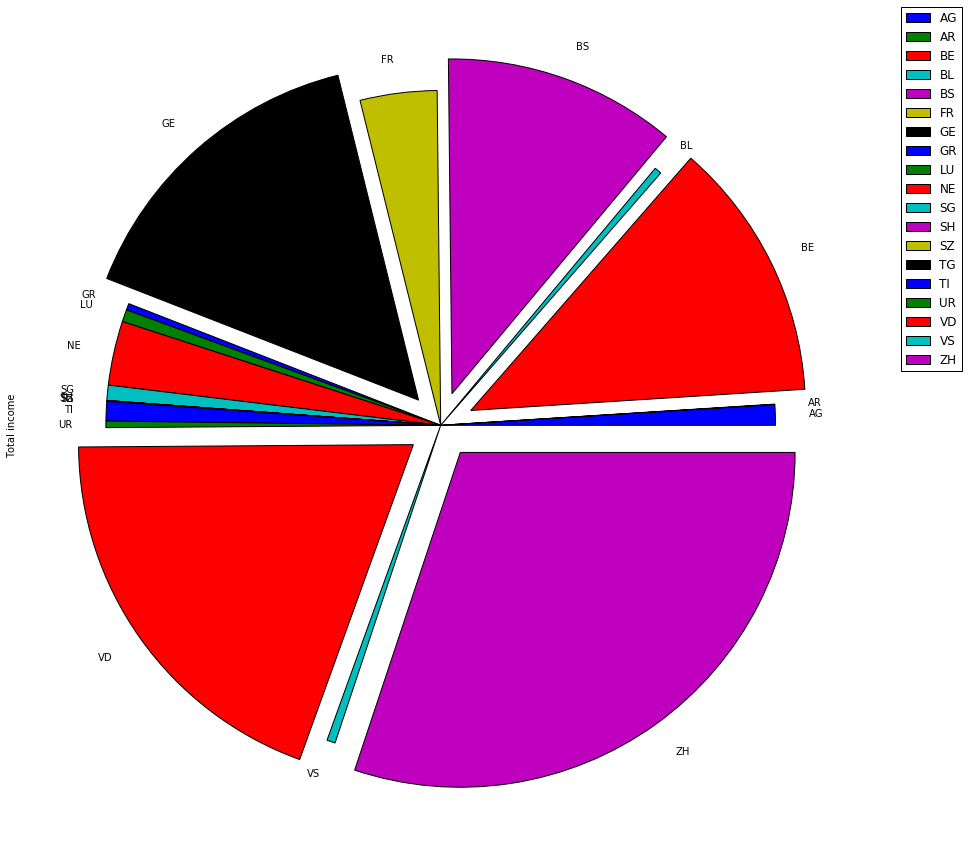

In [26]:
money = {}
for canton in np.unique(projects_data['Canton'].values):
    money[canton] = sum(projects_data[projects_data['Canton'] == canton]['Approved Amount'].values.astype(np.float)/10**6)

money = (pd.DataFrame(money, index = ['Total income'])).transpose()
mean = np.mean(money['Total income'].values)
explode = (money['Total income']> mean)*0.1
money.plot.pie(subplots=True, explode = explode, figsize=(15, 15))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()  

We can see in this *PIE GRAPH*, the pieces are a bit away from the center, are those that exceed the average. If we compare this with the **histogram graph**, we can see that the *Cantones*: **NE** y **FR** not appear. It may be that these two cantons are formed by a single university. As we can see in the diagram below, they are in the cantons, which have not appointed one/a few  university/universities receive more money compared to the rest.

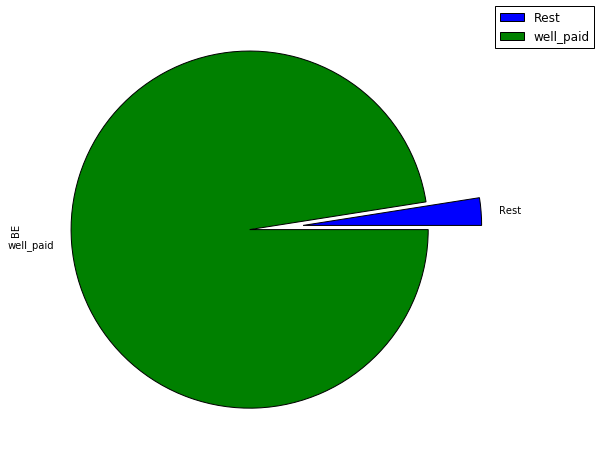

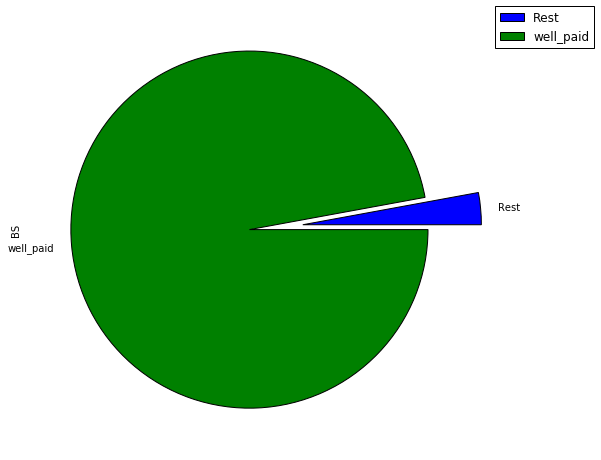

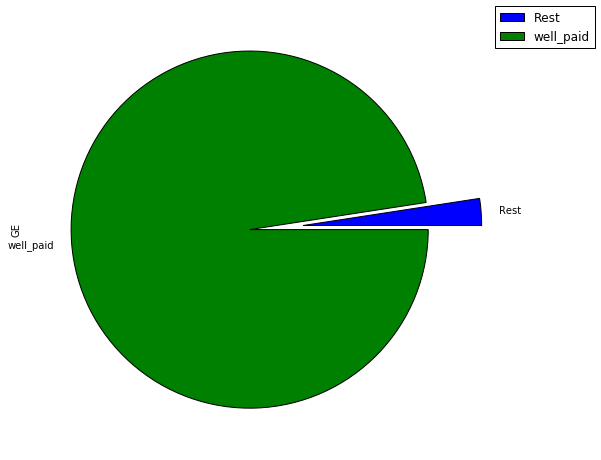

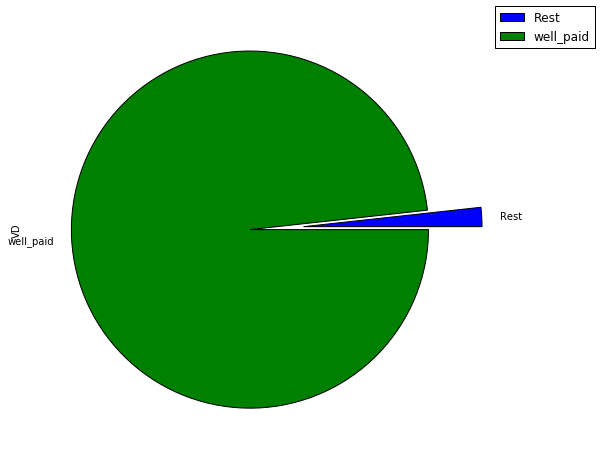

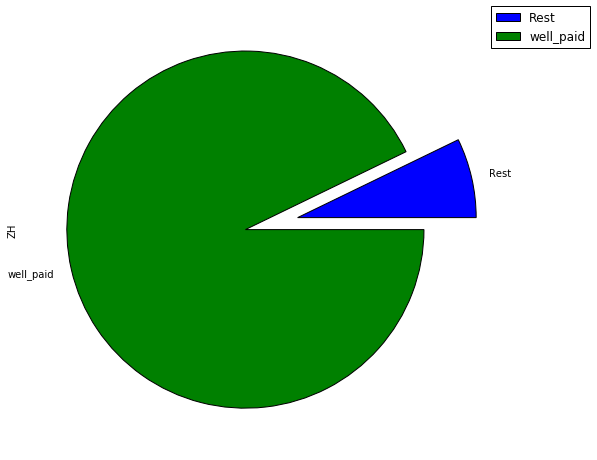

In [17]:
for i in money[money['Total income']> mean].index:
    total_best_universities = sum(selected_uni[selected_uni['Canton'] == i]['Total income'].values)
    rest = sum(money.loc[i].values) - total_best_universities
    pd.DataFrame({'well_paid' : [total_best_universities], 'Rest' : [rest]}, 
                 index = [i]).transpose().plot.pie(subplots=True, figsize=(8, 8), explode = [0.3, 0])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show() 